## Comparacion modelos CNN y RL-CNN

In [1]:
# libraries
from tensorflow import keras
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import scipy.io as sio
from scipy.fft import fft
import os
import matplotlib.pyplot as plt

In [2]:
# load the test X and y elements
with open('data/processed/trainX.npy', 'rb') as f:
    trainX = np.load(f)
with open('data/processed/trainy.npy', 'rb') as f:
    trainy = np.load(f)
with open('data/processed/testX.npy', 'rb') as f:
    testX = np.load(f)
with open('data/processed/testy.npy', 'rb') as f:
    testy = np.load(f)
with open('data/processed/valX.npy', 'rb') as f:
	valX = np.load(f)
with open('data/processed/valy.npy', 'rb') as f:
    valy = np.load(f)

In [3]:
# load ddqn model
ddqn_model = keras.models.load_model('models/ddqn_model_14.h5')

In [4]:
# load all cnn models and keep the one that gives the best results in a validation dataset
models_dir = 'models/'
cnn_models_paths = [filename for filename in os.listdir(models_dir) if filename.startswith('cnn_model')]
cnn_models = []
for cnn_model_path in cnn_models_paths:
    cnn_models.append((keras.models.load_model(models_dir+cnn_model_path)))

scores = []
for cnn_model in cnn_models:
    _, score = cnn_model.evaluate(valX, valy, verbose=0)
    scores.append(score)

best_model_index = np.argmax(scores)
cnn_model = cnn_models[best_model_index]

In [5]:
# CNN model
pred_test_cnn = cnn_model.predict(testX)

test_acc_cnn = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test_cnn,axis=1))
print('Test accuracy for CNN model: ',test_acc_cnn)

330/330 [==============================] - 3s 8ms/step
Test accuracy for CNN model:  0.9391180654338549


In [6]:
# DDQN (CNN-RL) model
pred_test_ddqn = ddqn_model.predict(testX)

test_acc_ddqn = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test_ddqn,axis=1))
print('Test accuracy for CNN-RL model: ',test_acc_ddqn)

330/330 [==============================] - 2s 6ms/step
Test accuracy for CNN-RL model:  0.8480796586059743


In [7]:
df_predictions = pd.DataFrame(np.argmax(pred_test_cnn,axis=1),columns=['CNN'])
df_predictions['DDQN'] = np.argmax(pred_test_ddqn,axis=1)
df_predictions['y_test'] = np.argmax(testy,axis=1)
df_predictions['diff'] = df_predictions['CNN']-df_predictions['DDQN']
df_predictions

,CNN,DDQN,y_test,diff
0,0,0,0,0
1,2,2,2,0
2,0,0,0,0
3,0,0,0,0
4,1,0,1,1
...,...,...,...,...
10540,1,1,1,0
10541,1,1,1,0
10542,2,0,2,2
10543,0,0,2,0


In [8]:
# Only plotting when different CNN and DDQN predictions, they don't match when predicting 0 and 2
fig = go.Figure()


fig.add_trace(go.Scatter(x=df_predictions.index, y=df_predictions[df_predictions['diff']!=0]['CNN'], mode='markers', marker_symbol='circle-open', marker_size=8, name='cnn'))
fig.add_trace(go.Scatter(x=df_predictions.index, y=df_predictions[df_predictions['diff']!=0]['DDQN'], mode='markers',marker_symbol='circle-open', marker_size=8, name='ddqn'))

fig.add_trace(go.Scatter(x=df_predictions.index, y=df_predictions[df_predictions['diff']!=0]['y_test'], mode='markers',marker_symbol='x', name='y_test'))


In [136]:
# Joint prediction of the two models

def join_predictions(pred_1,pred_2,w):
    concat_preds = np.stack((pred_1, pred_2), axis=-1)
    joint_preds = np.average(concat_preds, axis=2, weights=[w,1-w])
    joint_pred_weighted = joint_preds*[0.6,1,1]
    return joint_pred_weighted

best_w = None
best_acc = 0
for w in np.arange(0,1.1,0.1):
    pred_cnn = cnn_model.predict(valX,verbose=0)
    pred_ddqn = ddqn_model.predict(valX,verbose=0)
    joint_preds = join_predictions(pred_cnn,pred_ddqn,w)
    acc_joint = accuracy_score(np.argmax(valy,axis=1), np.argmax(joint_preds,axis=1))
    if acc_joint > best_acc:
        best_w = w
        best_acc = acc_joint
print(best_w, ', ', best_acc)

0.7000000000000001 ,  0.9374110953058321


In [137]:
joint_preds = join_predictions(pred_test_cnn, pred_test_ddqn, best_w)
test_acc_joint = accuracy_score(np.argmax(testy,axis=1), np.argmax(joint_preds,axis=1))
print('Test accuracy for union of both models: ',test_acc_joint)

Test accuracy for union of both models:  0.9402560455192034


In [138]:
print(classification_report(np.argmax(testy,axis=1), np.argmax(joint_preds,axis=1), target_names=['Healthy', 'OR fault', 'IR fault'],digits=4))

# El recall es la capacidad del modelo para detectar correctamente 
# todas las muestras positivas. Un alto recall indica que hay 
# pocos falsos negativos.
# Con el modelo conjunto mejoro el recall de las clases de fallos.

              precision    recall  f1-score   support

     Healthy     0.9373    0.9558    0.9465      3552
    OR fault     0.9615    0.9514    0.9564      3600
    IR fault     0.9209    0.9122    0.9165      3393

    accuracy                         0.9403     10545
   macro avg     0.9399    0.9398    0.9398     10545
weighted avg     0.9403    0.9403    0.9402     10545



In [139]:
# Construimos una visualización para la matriz de confusión
z_test = confusion_matrix(np.argmax(testy,axis=1), np.argmax(joint_preds,axis=1))
# Reformateo la matriz para que me quede mejor el gráfico
z_test[[0,2],:] = z_test[[2,0],:]
x = ['Healthy', 'OR fault', 'IR fault']
y = ['IR fault', 'OR fault', 'Healthy']

def format_text(z):
    return f'{z}<br>({z / np.sum(z_test) * 100:.1f}%)'

z_text = np.vectorize(format_text)(z_test)

heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='cividis')
heatmap.update_layout(title_text='Joint Model',height=350,width=500,
                      xaxis_title="Predicted Label",yaxis_title="True Label")
heatmap.show()

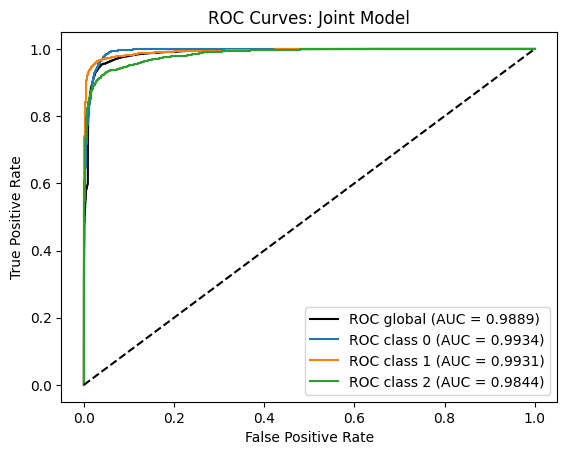

In [140]:
# Obtener las curvas ROC y los valores de AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], joint_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Obtener la curva ROC global
fpr["micro"], tpr["micro"], _ = roc_curve(testy.ravel(), joint_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficamos la curva ROC global y las curvas ROC de cada clase
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label="ROC global (AUC = {:.4f})".format(roc_auc["micro"]), color="black")
for i in range(3):
    plt.plot(fpr[i], tpr[i], label="ROC class {} (AUC = {:.4f})".format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Joint Model")
plt.legend()
plt.show()
